## Método theta. Exemplo 2.

Nesta notebook vamos aplicar o método de Euler, Euler regressivo e Trapezoidal ao PVI: 

$$y'=x-y^2,\quad y(0)=0.$$ 
Vamos comparar o desempenho desses métodos na aproximação de sua solução 
$$\varphi(x) = \sqrt{x} \frac{\pi I_{-\frac{2}{3}}(\frac{2}{3}x^{3/2}) - \sqrt{3} K_{-\frac{2}{3}}(\frac{2}{3}x^{3/2})} {\pi I_{\frac{1}{3}}(\frac{2}{3}x^{3/2}) + \sqrt{3} K_{\frac{1}{3}}(\frac{2}{3}x^{3/2})}$$
sobre o intervalo $[0,0.4]$.

Aqui as funções $I_{\alpha}$ e $K_{\alpha}$ representam as [funções de Bessel modificadas](https://en.wikipedia.org/wiki/Bessel_function#Modified_Bessel_functions) de primeiro e segundo tipo, respectivamente. 


In [1]:
#NumPy é a principal biblioteca para cálculos científicos de Python. Ela disponibiliza o objeto multidimensional 
#arranjo, objetos derivados, e um conjuntos de rotinas para operações rápidas sobre arranjos.
import numpy as np
#SymPy é uma biblioteca para cálculos simbólicos como integração exata, derivação, 
#resolução de equações, expansão em série de Taylor, etc
import sympy as sp 
#pandas é uma ferramenta de código aberto construída sobre Python para análise e manipulação de dados 
import pandas as pd
#Para mostrar tabelas mais bonitas
from IPython.display import HTML
#SciPy é uma biblioteca para computação científica. Importaremos o módulo com funções especiais
from scipy import special
#Matplotlib é uma biblioteca abrangente para criar visualizações estáticas, animadas e interativas em Python
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Implementação dos três métodos

Precisaremos definir no Python a função no termo direito da equação e a solução exata do PVI.

In [2]:
def f(a, b):# função no membro direito da equação
    return a-b**2
def phi(a):# solução exata da equação
    if a == 0:
        return 0
    else:
        return np.sqrt(a)*(np.pi*special.iv(-2/3, (2/3)*(np.sqrt(a))**3) - 
                       np.sqrt(3)* special.kv(-2/3, (2/3)*(np.sqrt(a))**3))/(np.pi*special.iv(1/3, (2/3)*(np.sqrt(a))**3) + 
                       np.sqrt(3)* special.kv(1/3, (2/3)*(np.sqrt(a))**3))
    
phi_1 = np.vectorize(phi, otypes=[np.float])

Vamos introduzir no Python algumas constantes necessárias.

In [3]:
# Condições iniciais
x0 = 0
y0 = 0
X = 0.4 # Extremo direito do intervalo

A seguir, vamos criar, para cada método, uma função que executa o passo do método. Cada função recebe x, y, h como entradas e retorna o próximo valor aproximado da solução.

É interessante implementar apenas o passo porque se formos usar um outro método de passo único poderemos aproveitar o resto do código.

In [4]:
#Passo do Método de Euler
def passo_Euler(x, y, h):
    """
    Executa uma iteração do método de Euler 
    aplicado à equação $y'=x-y^2$.
    
    Parâmetros
    ----------
    x : float
        ponto anterior da malha
    y : float.
        Aproximação da solução no ponto anterior.
    h : float
        Passo.
    
    Retorna
    -------
    y_novo : float
             Aproximação da solução no ponto atual.
    """
    y_novo = y + h*f(x,y)
    return y_novo   
#Passo do Método de Euler Regressivo
def passo_Euler_Regressivo(x, y, h):
    """
    Executa uma iteração do método de Euler Regressivo 
    aplicado à equação $y'=x-y^2$.
    
    Parâmetros
    ----------
    x : float
        ponto anterior da malha
    y : float.        
        Aproximação da solução no ponto anterior
    h : float
        Passo.
    
    Retorna
    -------
    y_novo : float
             Aproximação da solução no ponto atual.
    """
    y_novo = y + h*f(x,y)#preditor de Euler
    y_novo1 = y + h*f(x+h,y_novo)#primeira correção
    y_novo2 = y + h*f(x+h,y_novo1)#segunda correção
    return y_novo2  
#Passo do Método Trapezoidal
def passo_Trapezoidal(x, y, h):
    """
    Executa uma iteração do método Trapezoidal 
    aplicado à equação $y'=\frac{y+x^2-2}{x+1}.
    
    Parâmetros
    ----------
    u : float.
        Aproximação da solução no ponto anterior.
    h : float
        Passo.
    
    Retorna
    -------
    y_novo : float
             Aproximação da solução no ponto anterior.
    """
    y_novo = y + h*f(x,y)#preditor de Euler
    y_novo1 = y + (h/2)*(f(x,y)+f(x+h,y_novo))#primeira correção
    y_novo2 = y + (h/2)*(f(x,y)+f(x+h,y_novo1))#segunda correção
    return y_novo2  

A seguir, aplicaremos o método de Euler, o método de Euer Regressivo e o método Trapezoidal com 3 tamanhos de passo diferentes. Faremos isso para podermos analisar melhor os três métodos.

In [5]:
# Consideramos 3 tamanhos de passo possíveis
lista_h = [0.1, 0.01, 0.001]
# Lista com as malhas
lista_x = []
# Dicionario com as soluções aproximadas para cada malha e para cada método
lista_y = {'euler': [],'euler_regressivo': [],'trapezoidal': []}
# Dicionario com os erros absolutos de cada malha
erros_abs = {'euler': [],'euler_regressivo': [],'trapezoidal': []}
#Aplicamos os três métodos
for h in lista_h:
    N = int((X-x0) / h)   # quantidade de passos
    x = np.linspace(x0, X, num=N+1)  # malha 
    y_euler = np.empty_like(x) #inicializar z
    y_euler_regressivo = np.empty_like(x) #inicializar z
    y_trapezoidal = np.empty_like(x) #inicializar z
    x[0] = x0 #x inicial
    y_euler[0] = y0 #y inicial
    y_euler_regressivo[0] = y0 #y inicial
    y_trapezoidal[0] = y0 #y inicial    
    # N iterações dos três métodos.
    for n in range(N):
        y_euler[n + 1] = passo_Euler(x[n],y_euler[n],h) #iteração do método de Euler
        y_euler_regressivo[n + 1] = passo_Euler_Regressivo(x[n],y_euler_regressivo[n],h) #iteração do método de Euler Regressivo
        y_trapezoidal[n + 1] = passo_Trapezoidal(x[n],y_trapezoidal[n],h) #iteração do método Trapezoidal
    lista_x.append(x) #armazenar malha 
    lista_y['euler'].append(y_euler)  # armazenar arranjo com as aproximações de euler usando essa malha
    lista_y['euler_regressivo'].append(y_euler_regressivo)  # armazenar arranjo com as aproximações de euler usando essa malha
    lista_y['trapezoidal'].append(y_trapezoidal)  # armazenar arranjo com as aproximações de euler usando essa malha
    erros_abs['euler']. append(phi_1(x)-y_euler) # armazenar erro global das aproximações de euler usando essa malha 
    erros_abs['euler_regressivo']. append(phi_1(x)-y_euler_regressivo) # armazenar erro global das aproximações de euler usando essa malha 
    erros_abs['trapezoidal']. append(phi_1(x)-y_trapezoidal) # armazenar erro global das aproximações de euler usando essa malha     

## 2. Visualização dos resultados

Primeiro, para cada valor do passo, vamos construir uma tabela para comparar os três métodos.

In [6]:
#Notação científica
pd.set_option('display.float_format', '{:.4E}'.format)
#Pontos da malha cujos erros serão mostrados em formato char
x = np.array2string(np.linspace(0.1, 0.4, 4),precision=1, separator=',',floatmode = 'fixed')[1:-1].split(",")
#lista_df: Lista de dataframes. Um para cada valor de h
lista_df = []
for j in range(len(lista_h)):
    #d: Dicionário com os dados que serão tabelados
    d = {}
    d['h='+str(lista_h[j])+'_Pontos_x'] = x # Valores de x cujos erros serão exibidos
    #Método de Euler
    err_abs = erros_abs['euler'][j][int(0.1/lista_h[j]):int((X-x0)/lista_h[j] + 1):int(0.1/lista_h[j])]
    d['h='+str(lista_h[j])+'_Método de Euler_Erro Abs.'] = err_abs # coluna do erro absoluto
    d['h='+str(lista_h[j])+'_Método de Euler_Erro Rel.'] = err_abs/phi_1(lista_x[j][int(0.1/lista_h[j]):int((X-x0)/lista_h[j] + 1)\
                                                         :int(0.1/lista_h[j])])# coluna do erro relativo
    #Método de Euler Regressivo
    err_abs = erros_abs['euler_regressivo'][j][int(0.1/lista_h[j]):int((X-x0)/lista_h[j] + 1):int(0.1/lista_h[j])]
    d['h='+str(lista_h[j])+'_Método de Euler Regressivo_Erro Abs.'] = err_abs # coluna do erro absoluto
    d['h='+str(lista_h[j])+'_Método de Euler Regressivo_Erro Rel.'] = err_abs/phi_1(lista_x[j][int(0.1/lista_h[j]):int((X-x0)/lista_h[j] + 1)\
                                                         :int(0.1/lista_h[j])])# coluna do erro relativo
    #Método Trapezoidal
    err_abs = erros_abs['trapezoidal'][j][int(0.1/lista_h[j]):int((X-x0)/lista_h[j] + 1):int(0.1/lista_h[j])]
    d['h='+str(lista_h[j])+'_Método Trapezoidal_Erro Abs.'] = err_abs # coluna do erro absoluto
    d['h='+str(lista_h[j])+'_Método Trapezoidal_Erro Rel.'] = err_abs/phi_1(lista_x[j][int(0.1/lista_h[j]):int((X-x0)/lista_h[j] + 1)\
                                                         :int(0.1/lista_h[j])])# coluna do erro relativo
    
    df = pd.DataFrame(data=d) # Formação da tabela
    df.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) for c in df.columns])
    df.style.set_properties(**{'text-align': 'left'}) #Alinhamento à esquerda nas colunas
    lista_df.append(df) 
HTML(lista_df[0].to_html(index=False)) # Tirar a coluna de índices

In [7]:
HTML(lista_df[1].to_html(index=False))

In [8]:
HTML(lista_df[2].to_html(index=False))

Nas tabelas observamos que, além dos erros diminuírem com a diminuição do valor de $h$, os métodos de Euler explícito e implícito se comportam de maneira similar e o trapezoidal tem erros bem menores

A seguir plotamos a solução exata junto com as soluções aproximadas.

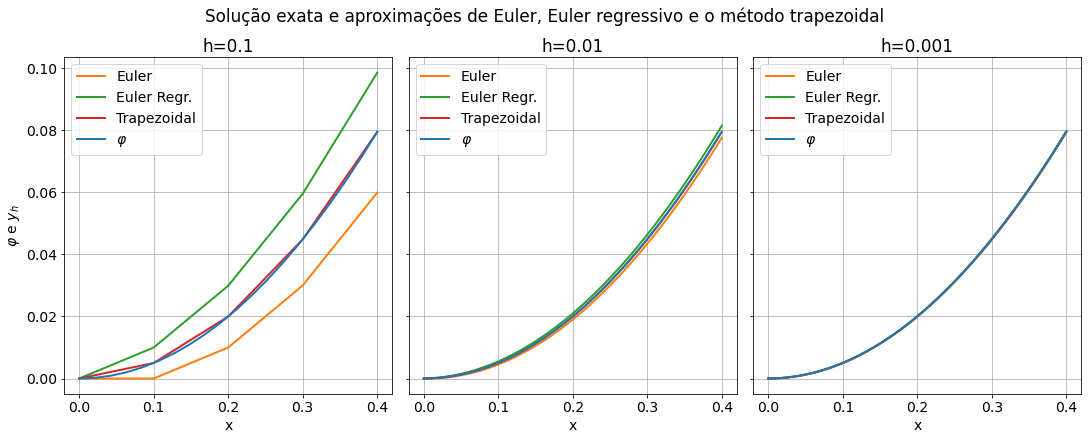

In [9]:
# Tamanho da letra nas figuras do Matplotlib.
plt.rcParams['font.size'] = 14
# Plotagem da solução exata junto com as três aproximações obtidas.
# Tamanho da figura e janelas
figsize = (15, 6)
colunas = 3
linhas = 1
# x para plotar a sol. exata
x1 = np.linspace(0, 0.4, 20)
y1 = phi_1(x1)
#figura
fig, axs = plt.subplots(linhas, colunas, figsize=figsize, constrained_layout=True,sharey=True)
fig.suptitle('Solução exata e aproximações de Euler, Euler regressivo e o método trapezoidal')
axs[0].set_ylabel(r'$\varphi$ e $y_h$')
for j in range(len(lista_h)):
    axs[j].set_title('h=%s' %str(lista_h[j]))
    axs[j].set_xlabel('x') 
    axs[j].grid(True)
    axs[j].plot(lista_x[j], lista_y['euler'][j], label='Euler', \
         color = 'C1', linestyle='-', linewidth=2) 
    axs[j].plot(lista_x[j], lista_y['euler_regressivo'][j], label='Euler Regr.', \
         color = 'C2', linestyle='-', linewidth=2) 
    axs[j].plot(lista_x[j], lista_y['trapezoidal'][j], label='Trapezoidal', \
         color = 'C3', linestyle='-', linewidth=2) 
    axs[j].plot(x1, phi_1(x1), label=r'$\varphi$', color = 'C0', linestyle='-', linewidth=2)  
    axs[j].legend()
    
    

A seguir plotamos apenas os erros.

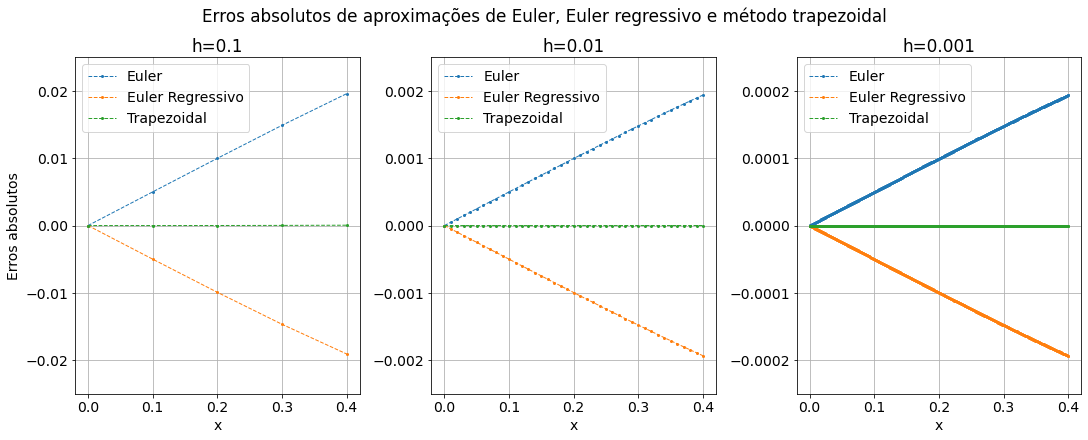

In [10]:
# Plotagem dos erros das aproximações obtidas.
# Tamanho da figura e janelas
figsize = (15, 6)
colunas = 3
linhas = 1
#figura
fig, axs = plt.subplots(linhas, colunas, figsize=figsize, constrained_layout=True)
fig.suptitle(r"Erros absolutos de aproximações de Euler, Euler regressivo e método trapezoidal")
axs[0].set_ylabel('Erros absolutos')
axs[0].set_ylim((-0.025, 0.025))
axs[1].set_ylim((-0.0025, 0.0025))
axs[2].set_ylim((-0.00025, 0.00025))
for j in range(len(lista_h)):
    axs[j].set_title('h=%s' %str(lista_h[j]))
    axs[j].set_xlabel('x') 
    axs[j].grid(True)
    axs[j].plot(lista_x[j], erros_abs['euler'][j], label='Euler',\
             color = 'C0', marker='o', linewidth=1, linestyle='--', markersize=2) 
    axs[j].plot(lista_x[j], erros_abs['euler_regressivo'][j], label='Euler Regressivo',\
             color = 'C1', marker='o', linewidth=1, linestyle='--', markersize=2) 
    axs[j].plot(lista_x[j], erros_abs['trapezoidal'][j], label='Trapezoidal',\
             color = 'C2', marker='o', linewidth=1, linestyle='--', markersize=2) 
    axs[j].legend()

No gráfico a seguir, também plotamos os erros, só que usando a escala logarítmica no eixo y.

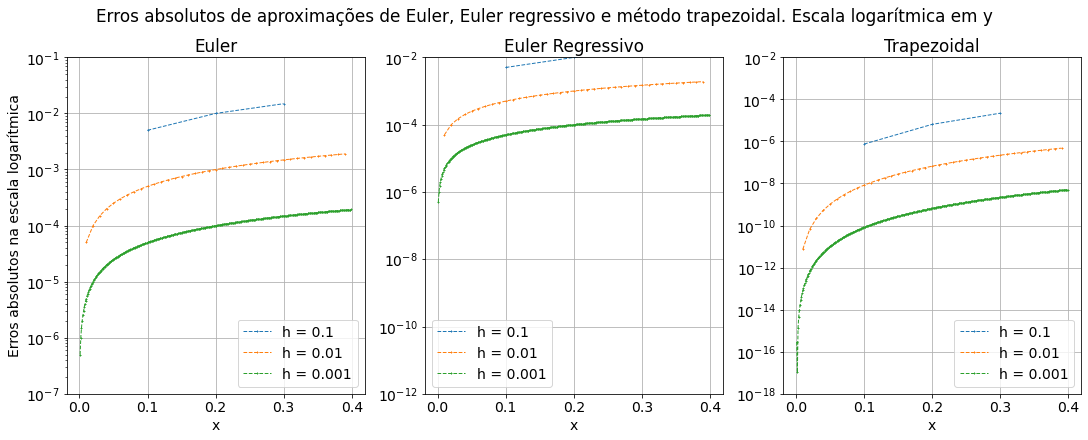

In [11]:
# Plotagem dos erros das aproximações obtidas.
#lista com os nomes do métodos
lista_nomes = ['euler', 'euler_regressivo', 'trapezoidal']
lista_nomes1 = ['Euler', 'Euler Regressivo', 'Trapezoidal']
# Tamanho da figura e janelas
figsize = (15, 6)
colunas = 3
linhas = 1
#figura
fig, axs = plt.subplots(linhas, colunas, figsize=figsize, constrained_layout=True)
fig.suptitle(r"Erros absolutos de aproximações de Euler, Euler regressivo e método trapezoidal. Escala logarítmica em y")
axs[0].set_ylabel('Erros absolutos na escala logarítmica')
axs[0].set_ylim(10**-7, 10**-1)  # especifica limites no eixo y
axs[1].set_ylim(10**-12, 10**-2)  # especifica limites no eixo y
axs[2].set_ylim(10**-18, 10**-2)  # especifica limites no eixo y
for j in range(len(lista_nomes)):
    axs[j].set_title(lista_nomes1[j])
    axs[j].set_xlabel('x') 
    axs[j].grid(True)
    axs[j].plot(lista_x[0][1:-1], np.abs(erros_abs[lista_nomes[j]][0][1:-1]), label='h = 0.1',\
             color = 'C0', marker='+', linewidth=1, linestyle='--', markersize=2) 
    axs[j].plot(lista_x[1][1:-1], np.abs(erros_abs[lista_nomes[j]][1][1:-1]), label='h = 0.01',\
             color = 'C1', marker='+', linewidth=1, linestyle='--', markersize=2) 
    axs[j].plot(lista_x[2][1:-1], np.abs(erros_abs[lista_nomes[j]][2][1:-1]), label='h = 0.001',\
             color = 'C2', marker='+', linewidth=1, linestyle='--', markersize=2) 
    axs[j].semilogy()
    axs[j].legend()

Poderíamos usar a escala logarítmica no eixo $x$ também. No próximo gráfico representamos $E(h)$ como função de $h$ usando a escala logarítmica nos dois eixos.

1.0024351862693037 0.9967109750868871 2.0001111247247803


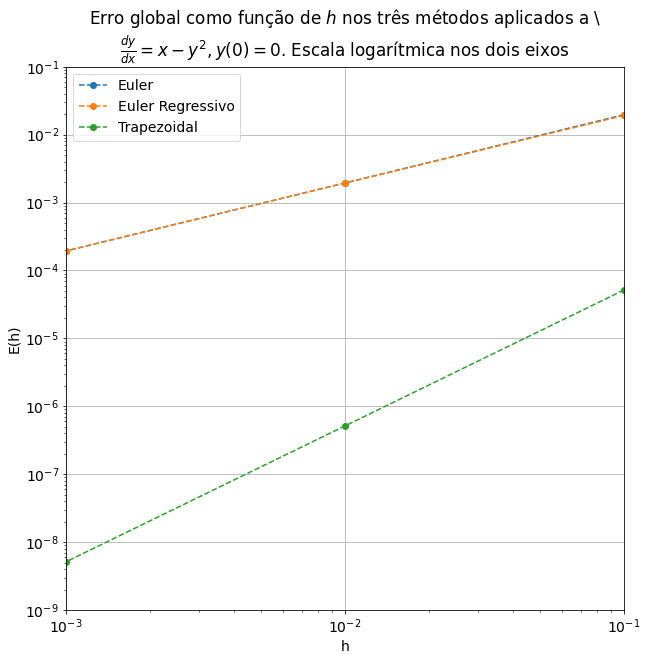

In [13]:
# Plotagem de E(h) como função de h na escala logarítmica nos dois eixos.
#Dicionario com as funções E para cada método
E = {}
E['euler'] = np.array([np.max(np.abs(erros_abs['euler'][j])) for j in range(len(lista_h))]) # Cálculo de E(h), Euler
E['euler_regressivo'] = np.array([np.max(np.abs(erros_abs['euler_regressivo'][j])) for j in range(len(lista_h))]) # Cálculo de E(h), Euler regressivo
E['trapezoidal'] = np.array([np.max(np.abs(erros_abs['trapezoidal'][j])) for j in range(len(lista_h))]) # Cálculo de E(h), trapezoidal
plt.figure(figsize=(10.0, 10.0))  # Fixar o tamanho da figura
plt.title(r"Erro global como função de $h$ nos três métodos aplicados a \
$\frac{dy}{dx}= x-y^2, y(0) = 0$. Escala logarítmica nos dois eixos")  # título
plt.xlabel('h')
plt.ylabel(r'E(h)')
plt.xlim(10**-3, 10**-1)  # especifica limites no eixo x
plt.ylim(10**-9, 10**-1)  # especifica limites no eixo y
plt.grid(True)  # set a background grid to improve readabilityfor j in range(len(lista_h)):
# plotar log-log 
plt.loglog(lista_h, E['euler'], color='C0', linestyle='--', marker='o', label='Euler')  # plotar log-log Euler
plt.loglog(lista_h, E['euler_regressivo'], color='C1', linestyle='--', marker='o', label='Euler Regressivo')  # plotar log-log Euler Regressivo
plt.loglog(lista_h, E['trapezoidal'], color='C2', linestyle='--', marker='o', label='Trapezoidal')  # plotar log-log Trapezoidal
plt.legend()
#Coeficiente angular dos segmentos 
print((np.log(E['euler'][0])- np.log(E['euler'][2]))/(np.log(lista_h[0]) - np.log(lista_h[2])),\
      (np.log(E['euler_regressivo'][0])- np.log(E['euler_regressivo'][2]))/(np.log(lista_h[0]) - np.log(lista_h[2])), \
      (np.log(E['trapezoidal'][0])- np.log(E['trapezoidal'][2]))/(np.log(lista_h[0]) - np.log(lista_h[2])))

No gráfico podemos verificar que neste exemplo,
* $E(h)$ diminui com $h$. 
* O erro global dos métodos de Euler e Euler Regressivo se comportam de maneira bastante parecida. Como sabemos que o método de Euler é de primeira ordem, o de Euler Regressivo parece sê-lo também. Os coeficientes angulares desses métodos são aproximadamente iguais a 1.
* O erro global do método Trapezoidal toma valores significativamente menores. Além disso, o coeficiente angular do segmento verde é aproximadamente 2. Isto é um indicativo de que o método é de ordem dois.

## 3. Conclusões 

* Nesta notebook estudamos o comportamento dos método de Euler, Euler Regressivo e Trapezoidal para o caso particular do PVI $$\frac{dy}{dx}= x-y^2, y(0) = 0.$$ 

* Os resultados confirmam o fato do método de Euler ser de primeira ordem e indicam que o método de Euler Regressivo é de primeira ordem e o Trapezoidal, de ordem dois. 


## Desafios:

1. Implementar aproximações sucessivas com um erro máximo admitido entre dois valores consecutivos: $|y_{j+1}^{(k+1)} - y_{j+1}^{(k)}|<\delta$.
2. Comparar os tempos de execução e outras medidas de eficiência dos programas. Referência: Seção H.8, pags. 896 - 899, A primer on Scientific Programming with Python.
3. Visualizar o comportamento dos erros de truncamento local.    